## Unsupervised Learning Trading Strategy


* Download/Load NIFTY50 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization OR equal weighted.
* Visualize Portfolio returns and compare to NIFTY50 returns

### All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

### 1. Download/Load Nifty50 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np #The Numpy numerical computing library
import pandas as pd #The Pandas data science library
import requests #The requests library for HTTP requests in Python
import xlsxwriter #The XlsxWriter libarary for 
import math #The Python math module
from scipy import stats #The SciPy stats module
import yfinance as yf
import datetime as dt
import pandas_ta 
import matplotlib.pyplot as plt 

In [3]:
sp_500_stocks = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50")[2]

sp_500_stocks = sp_500_stocks['Symbol'].add(".NS")

stocks = sp_500_stocks.unique().tolist()

In [4]:
end = dt.date.today()
start = end - pd.Timedelta(days= 252*15)
end
start

datetime.date(2013, 7, 22)

In [5]:
stocks_df = yf.download(stocks, start, end).stack()

[*********************100%%**********************]  50 of 50 completed


In [6]:
df = stocks_df.copy()

df.columns = df.columns.str.lower()

df.index.names = ['date', 'ticker']

In [7]:
df

adj close        close         high          low  \
date       ticker                                                              
2013-07-22 ADANIENT.NS      26.696838    30.501736    30.953897    30.011255   
           ADANIPORTS.NS   137.291321   145.649994   146.850006   144.000000   
           APOLLOHOSP.NS   932.560852   974.049988   998.900024   969.000000   
           ASIANPAINT.NS   468.455322   505.029968   522.494995   496.725006   
           AXISBANK.NS     230.324203   240.020004   242.160004   235.690002   
...                               ...          ...          ...          ...   
2023-11-24 TECHM.NS       1197.849976  1197.849976  1214.949951  1195.099976   
           TITAN.NS       3396.949951  3396.949951  3419.100098  3382.550049   
           ULTRACEMCO.NS  8556.200195  8556.200195  8655.000000  8545.049805   
           UPL.NS          558.950012   558.950012   568.349976   558.049988   
           WIPRO.NS        396.000000   396.000000   403.500000   395.549988   

                                 open     volume  
date       ticker                                 
2013-07-22 ADANIENT.NS      30.348461  6459628.0  
           ADANIPORTS.NS   146.000000   518078.0  
           APOLLOHOSP.NS   978.150024    42435.0  
           ASIANPAINT.NS   518.989990  1718900.0  
           AXISBANK.NS     238.800003  6446280.0  
...                               ...        ...  
2023-11-24 TECHM.NS       1212.050049   884921.0  
           TITAN.NS       3406.000000   589530.0  
           ULTRACEMCO.NS  8638.000000   197278.0  
           UPL.NS          565.500000   868199.0  
           WIPRO.NS        402.500000  3125283.0  

[124721 rows x 6 columns]

###  2. Calculate features and technical indicators for each stock.


Garman-Klass Volatility

RSI

Bollinger Bands

ATR

MACD

Dollar Volume

In [8]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [9]:
df

adj close        close         high          low  \
date       ticker                                                              
2013-07-22 ADANIENT.NS      26.696838    30.501736    30.953897    30.011255   
           ADANIPORTS.NS   137.291321   145.649994   146.850006   144.000000   
           APOLLOHOSP.NS   932.560852   974.049988   998.900024   969.000000   
           ASIANPAINT.NS   468.455322   505.029968   522.494995   496.725006   
           AXISBANK.NS     230.324203   240.020004   242.160004   235.690002   
...                               ...          ...          ...          ...   
2023-11-24 TECHM.NS       1197.849976  1197.849976  1214.949951  1195.099976   
           TITAN.NS       3396.949951  3396.949951  3419.100098  3382.550049   
           ULTRACEMCO.NS  8556.200195  8556.200195  8655.000000  8545.049805   
           UPL.NS          558.950012   558.950012   568.349976   558.049988   
           WIPRO.NS        396.000000   396.000000   403.500000   395.549988   

                                 open     volume  garman_klass_vol        rsi  \
date       ticker                                                               
2013-07-22 ADANIENT.NS      30.348461  6459628.0         -0.005871        NaN   
           ADANIPORTS.NS   146.000000   518078.0         -0.001269        NaN   
           APOLLOHOSP.NS   978.150024    42435.0         -0.000418        NaN   
           ASIANPAINT.NS   518.989990  1718900.0         -0.002775        NaN   
           AXISBANK.NS     238.800003  6446280.0         -0.000138        NaN   
...                               ...        ...               ...        ...   
2023-11-24 TECHM.NS       1212.050049   884921.0          0.000082  54.519967   
           TITAN.NS       3406.000000   589530.0          0.000055  62.430377   
           ULTRACEMCO.NS  8638.000000   197278.0          0.000047  51.595311   
           UPL.NS          565.500000   868199.0          0.000115  42.789434   
           WIPRO.NS        402.500000  3125283.0          0.000096  49.373590   

                            bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                            
2013-07-22 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN   
...                            ...       ...       ...       ...       ...   
2023-11-24 TECHM.NS       6.987459  7.054497  7.121534  0.126248  0.475602   
           TITAN.NS       8.042623  8.096703  8.150782  1.208075  1.454812   
           ULTRACEMCO.NS  9.023818  9.059833  9.095848  0.442678  0.722121   
           UPL.NS         6.283963  6.317785  6.351606 -0.864416 -0.717854   
           WIPRO.NS       5.923348  5.964650  6.005951 -0.277051 -0.063539   

                          dollar_volume  
date       ticker                        
2013-07-22 ADANIENT.NS       172.451645  
           ADANIPORTS.NS      71.127613  
           APOLLOHOSP.NS      39.573220  
           ASIANPAINT.NS     805.227853  
           AXISBANK.NS      1484.734306  
...                                 ...  
2023-11-24 TECHM.NS         1060.002598  
           TITAN.NS         2002.603905  
           ULTRACEMCO.NS    1687.950062  
           UPL.NS            485.279842  
           WIPRO.NS         1237.612068  

[124721 rows x 14 columns]

### 3. Aggregate to monthly level stocks for each month.

In [10]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2013-08-31 ADANIENT.NS       326.923132    19.990320         -0.003493   
           ADANIPORTS.NS     286.666968   119.579399          0.000430   
           APOLLOHOSP.NS     191.474018   832.326599         -0.000283   
           ASIANPAINT.NS     528.855187   390.464355          0.002145   
           AXISBANK.NS      3984.585040   159.860443          0.002239   
...                                 ...          ...               ...   
2023-11-30 TECHM.NS         1710.968893  1197.849976          0.000082   
           TITAN.NS         2706.355521  3396.949951          0.000055   
           ULTRACEMCO.NS    1694.207192  8556.200195          0.000047   
           UPL.NS            931.701795   558.950012          0.000115   
           WIPRO.NS         1416.929269   396.000000          0.000096   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2013-08-31 ADANIENT.NS    30.474380  3.060348  3.166551  3.272754 -0.585664   
           ADANIPORTS.NS  41.695882  4.708278  4.832050  4.955822 -0.840446   
           APOLLOHOSP.NS  39.646721  6.688648  6.779697  6.870746 -0.498534   
           ASIANPAINT.NS  38.252524  5.874332  5.994426  6.114520 -0.780217   
           AXISBANK.NS    24.359194  5.064733  5.267206  5.469679 -0.627402   
...                             ...       ...       ...       ...       ...   
2023-11-30 TECHM.NS       54.519967  6.987459  7.054497  7.121534  0.126248   
           TITAN.NS       62.430377  8.042623  8.096703  8.150782  1.208075   
           ULTRACEMCO.NS  51.595311  9.023818  9.059833  9.095848  0.442678   
           UPL.NS         42.789434  6.283963  6.317785  6.351606 -0.864416   
           WIPRO.NS       49.373590  5.923348  5.964650  6.005951 -0.277051   

                              macd  
date       ticker                   
2013-08-31 ADANIENT.NS   -0.131216  
           ADANIPORTS.NS -0.587860  
           APOLLOHOSP.NS -0.775848  
           ASIANPAINT.NS -1.052890  
           AXISBANK.NS   -1.499049  
...                            ...  
2023-11-30 TECHM.NS       0.475602  
           TITAN.NS       1.454812  
           ULTRACEMCO.NS  0.722121  
           UPL.NS        -0.717854  
           WIPRO.NS      -0.063539  

[6061 rows x 9 columns]

#### Calculate 5-year rolling average of dollar volume for each stocks.

In [21]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2014-08-31 ADANIENT.NS      69.090858         -0.001335  54.392329  4.131004   
           ADANIPORTS.NS   269.565765         -0.001060  55.803963  5.486335   
           APOLLOHOSP.NS  1135.536865         -0.000492  62.647264  6.799745   
           ASIANPAINT.NS   584.746704         -0.001156  58.646045  6.336360   
           AXISBANK.NS     385.171936         -0.000214  55.630777  5.887881   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1197.849976          0.000082  54.519967  6.987459   
           TITAN.NS       3396.949951          0.000055  62.430377  8.042623   
           ULTRACEMCO.NS  8556.200195          0.000047  51.595311  9.023818   
           UPL.NS          558.950012          0.000115  42.789434  6.283963   
           WIPRO.NS        396.000000          0.000096  49.373590  5.923348   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2014-08-31 ADANIENT.NS    4.236621  4.342237 -0.564027 -0.078004   0.103965   
           ADANIPORTS.NS  5.579837  5.673338 -0.434030  0.460115   0.085588   
           APOLLOHOSP.NS  6.956278  7.112810 -0.523742  0.539910   0.164132   
           ASIANPAINT.NS  6.365558  6.394755 -1.091939 -0.126889  -0.007079   
           AXISBANK.NS    5.936163  5.984445 -1.218571  0.102507   0.014298   
...                            ...       ...       ...       ...        ...   
2023-11-30 TECHM.NS       7.054497  7.121534  0.126248  0.475602   0.068494   
           TITAN.NS       8.096703  8.150782  1.208075  1.454812   0.064991   
           ULTRACEMCO.NS  9.059833  9.095848  0.442678  0.722121   0.015904   
           UPL.NS         6.317785  6.351606 -0.864416 -0.717854   0.034135   
           WIPRO.NS       5.964650  6.005951 -0.277051 -0.063539   0.037192   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2014-08-31 ADANIENT.NS     0.036690   0.007019   0.115191   0.071287   
           ADANIPORTS.NS   0.079383   0.076651   0.092212   0.067330   
           APOLLOHOSP.NS   0.088745   0.091235   0.042225   0.039250   
           ASIANPAINT.NS   0.025106   0.074137   0.048673   0.025015   
           AXISBANK.NS     0.017411   0.030089   0.079667   0.063216   
...                             ...        ...        ...        ...   
2023-11-30 TECHM.NS       -0.004934   0.002438   0.022554   0.016539   
           TITAN.NS        0.038657   0.030469   0.031868   0.041047   
           ULTRACEMCO.NS   0.018089   0.010289   0.014800   0.018916   
           UPL.NS         -0.047625  -0.018497  -0.030722  -0.022022   
           WIPRO.NS       -0.012453  -0.010225  -0.003184   0.002543   

                          return_12m  
date       ticker                     
2014-08-31 ADANIENT.NS      0.108877  
           ADANIPORTS.NS    0.070083  
           APOLLOHOSP.NS    0.026224  
           ASIANPAINT.NS    0.034226  
           AXISBANK.NS      0.076034  
...                              ...  
2023-11-30 TECHM.NS         0.014182  
           TITAN.NS         0.021088  
           ULTRACEMCO.NS    0.016329  
           UPL.NS          -0.027069  
           WIPRO.NS        -0.002056  

[5461 rows x 14 columns]

### 4. Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method 
.pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [22]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2015-08-31 ADANIENT.NS      39.693897         -0.000491  38.262542  3.635761   
           ADANIPORTS.NS   339.829041          0.000904  56.009033  5.742562   
           APOLLOHOSP.NS  1302.831543          0.000864  50.974096  7.099807   
           ASIANPAINT.NS   801.663086         -0.001506  49.035922  6.671448   
           AXISBANK.NS     496.271118          0.000319  37.322573  6.156492   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1197.849976          0.000082  54.519967  6.987459   
           TITAN.NS       3396.949951          0.000055  62.430377  8.042623   
           ULTRACEMCO.NS  8556.200195          0.000047  51.595311  9.023818   
           UPL.NS          558.950012          0.000115  42.789434  6.283963   
           WIPRO.NS        396.000000          0.000096  49.373590  5.923348   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2015-08-31 ADANIENT.NS    3.821778  4.007794 -0.551464 -0.144441  -0.137694   
           ADANIPORTS.NS  5.813724  5.884886  0.052978  0.447671   0.093693   
           APOLLOHOSP.NS  7.181351  7.262896 -0.164526 -0.395317  -0.014450   
           ASIANPAINT.NS  6.726385  6.781321 -0.528594 -0.175100  -0.038740   
           AXISBANK.NS    6.278797  6.401102  0.221919 -1.561897  -0.114647   
...                            ...       ...       ...       ...        ...   
2023-11-30 TECHM.NS       7.054497  7.121534  0.126248  0.475602   0.068494   
           TITAN.NS       8.096703  8.150782  1.208075  1.454812   0.064991   
           ULTRACEMCO.NS  9.059833  9.095848  0.442678  0.722121   0.015904   
           UPL.NS         6.317785  6.351606 -0.864416 -0.717854   0.034135   
           WIPRO.NS       5.964650  6.005951 -0.277051 -0.063539   0.037192   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2015-08-31 ADANIENT.NS    -0.077028  -0.269669  -0.138833  -0.055267   
           ADANIPORTS.NS   0.074446   0.031521   0.004910   0.023131   
           APOLLOHOSP.NS   0.011369   0.035428   0.005541   0.016078   
           ASIANPAINT.NS   0.059931   0.027367   0.009340   0.015260   
           AXISBANK.NS    -0.043076  -0.043779  -0.016959   0.006881   
...                             ...        ...        ...        ...   
2023-11-30 TECHM.NS       -0.004934   0.002438   0.022554   0.016539   
           TITAN.NS        0.038657   0.030469   0.031868   0.041047   
           ULTRACEMCO.NS   0.018089   0.010289   0.014800   0.018916   
           UPL.NS         -0.047625  -0.018497  -0.030722  -0.022022   
           WIPRO.NS       -0.012453  -0.010225  -0.003184   0.002543   

                          return_12m  
date       ticker                     
2015-08-31 ADANIENT.NS     -0.045135  
           ADANIPORTS.NS    0.019490  
           APOLLOHOSP.NS    0.011519  
           ASIANPAINT.NS    0.026641  
           AXISBANK.NS      0.021344  
...                              ...  
2023-11-30 TECHM.NS         0.014182  
           TITAN.NS         0.021088  
           ULTRACEMCO.NS    0.016329  
           UPL.NS          -0.027069  
           WIPRO.NS        -0.002056  

[4861 rows x 14 columns]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4861 entries, (Timestamp('2015-08-31 00:00:00'), 'ADANIENT.NS') to (Timestamp('2023-11-30 00:00:00'), 'WIPRO.NS')
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         4861 non-null   float64
 1   garman_klass_vol  4861 non-null   float64
 2   rsi               4861 non-null   float64
 3   bb_low            4861 non-null   float64
 4   bb_mid            4861 non-null   float64
 5   bb_high           4861 non-null   float64
 6   atr               4861 non-null   float64
 7   macd              4861 non-null   float64
 8   return_1m         4861 non-null   float64
 9   return_2m         4861 non-null   float64
 10  return_3m         4861 non-null   float64
 11  return_6m         4861 non-null   float64
 12  return_9m         4861 non-null   float64
 13  return_12m        4861 non-null   float64
dtypes: float64(14)
memory usage: 548.8+ KB


### 5. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.


### K-Means Clustering

You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [24]:
from sklearn.cluster import KMeans


### Apply pre-defined centroids.

In [25]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 14))

initial_centroids[:, 2] = target_rsi_values

initial_centroids

array([[ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

The initial centroids is locate the centre and separate the cluster based on the target rsi values. 

In [26]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df


In [27]:
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2015-08-31 ADANIENT.NS      39.693897         -0.000491  38.262542  3.635761   
           ADANIPORTS.NS   339.829041          0.000904  56.009033  5.742562   
           APOLLOHOSP.NS  1302.831543          0.000864  50.974096  7.099807   
           ASIANPAINT.NS   801.663086         -0.001506  49.035922  6.671448   
           AXISBANK.NS     496.271118          0.000319  37.322573  6.156492   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1197.849976          0.000082  54.519967  6.987459   
           TITAN.NS       3396.949951          0.000055  62.430377  8.042623   
           ULTRACEMCO.NS  8556.200195          0.000047  51.595311  9.023818   
           UPL.NS          558.950012          0.000115  42.789434  6.283963   
           WIPRO.NS        396.000000          0.000096  49.373590  5.923348   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2015-08-31 ADANIENT.NS    3.821778  4.007794 -0.551464 -0.144441  -0.137694   
           ADANIPORTS.NS  5.813724  5.884886  0.052978  0.447671   0.093693   
           APOLLOHOSP.NS  7.181351  7.262896 -0.164526 -0.395317  -0.014450   
           ASIANPAINT.NS  6.726385  6.781321 -0.528594 -0.175100  -0.038740   
           AXISBANK.NS    6.278797  6.401102  0.221919 -1.561897  -0.114647   
...                            ...       ...       ...       ...        ...   
2023-11-30 TECHM.NS       7.054497  7.121534  0.126248  0.475602   0.068494   
           TITAN.NS       8.096703  8.150782  1.208075  1.454812   0.064991   
           ULTRACEMCO.NS  9.059833  9.095848  0.442678  0.722121   0.015904   
           UPL.NS         6.317785  6.351606 -0.864416 -0.717854   0.034135   
           WIPRO.NS       5.964650  6.005951 -0.277051 -0.063539   0.037192   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2015-08-31 ADANIENT.NS    -0.077028  -0.269669  -0.138833  -0.055267   
           ADANIPORTS.NS   0.074446   0.031521   0.004910   0.023131   
           APOLLOHOSP.NS   0.011369   0.035428   0.005541   0.016078   
           ASIANPAINT.NS   0.059931   0.027367   0.009340   0.015260   
           AXISBANK.NS    -0.043076  -0.043779  -0.016959   0.006881   
...                             ...        ...        ...        ...   
2023-11-30 TECHM.NS       -0.004934   0.002438   0.022554   0.016539   
           TITAN.NS        0.038657   0.030469   0.031868   0.041047   
           ULTRACEMCO.NS   0.018089   0.010289   0.014800   0.018916   
           UPL.NS         -0.047625  -0.018497  -0.030722  -0.022022   
           WIPRO.NS       -0.012453  -0.010225  -0.003184   0.002543   

                          return_12m  cluster  
date       ticker                              
2015-08-31 ADANIENT.NS     -0.045135        2  
           ADANIPORTS.NS    0.019490        2  
           APOLLOHOSP.NS    0.011519        1  
           ASIANPAINT.NS    0.026641        0  
           AXISBANK.NS      0.021344        0  
...                              ...      ...  
2023-11-30 TECHM.NS         0.014182        1  
           TITAN.NS         0.021088        3  
           ULTRACEMCO.NS    0.016329        2  
           UPL.NS          -0.027069        1  
           WIPRO.NS        -0.002056        1  

[4861 rows x 15 columns]

In [28]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


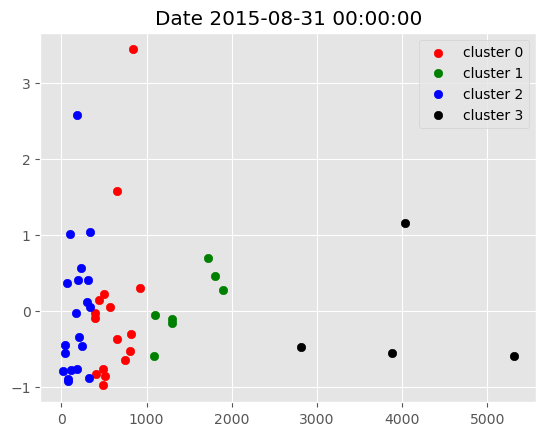

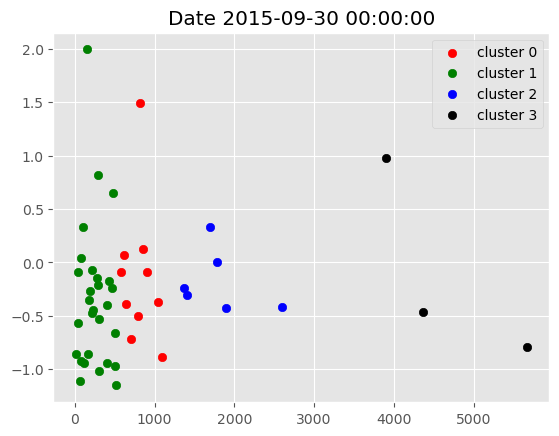

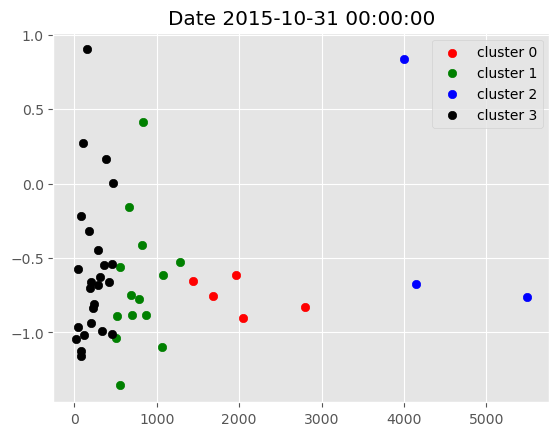

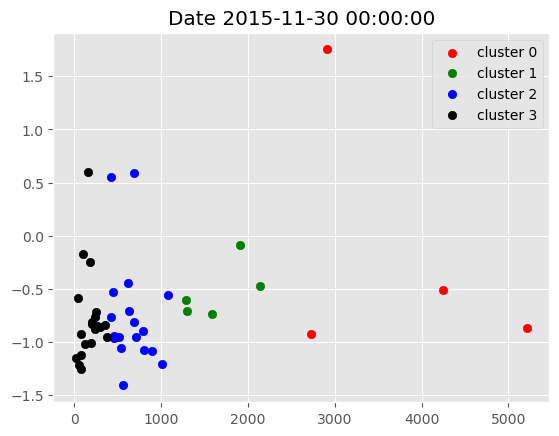

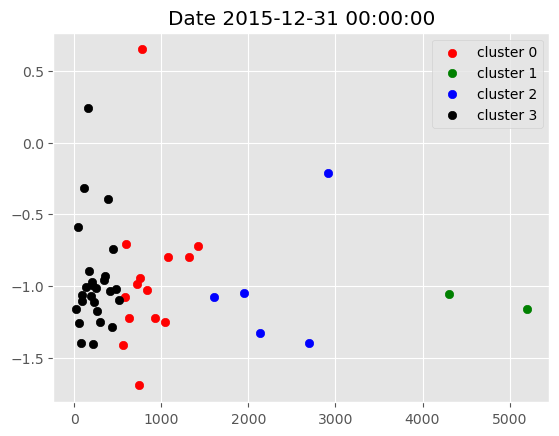

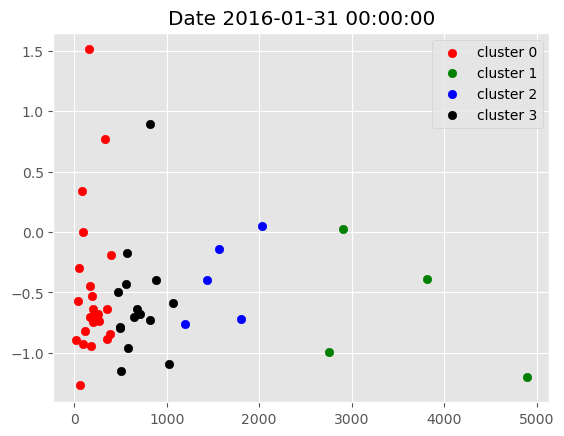

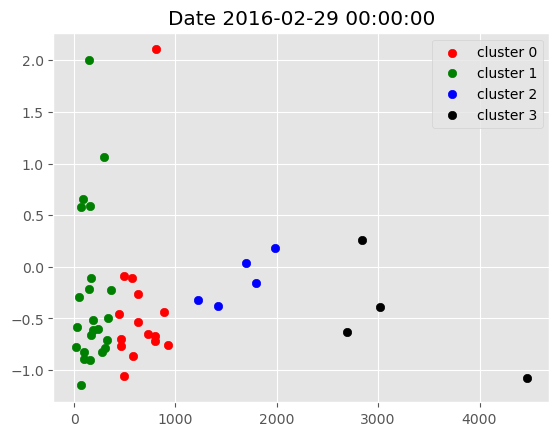

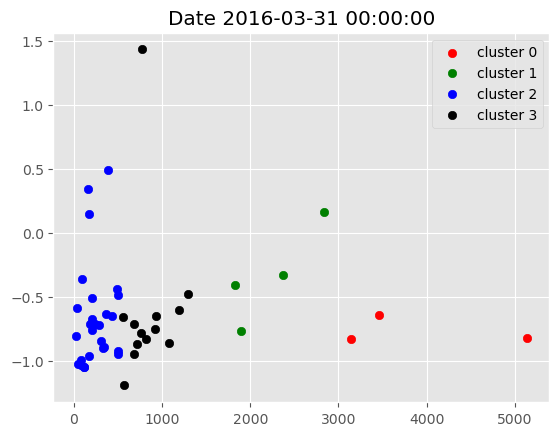

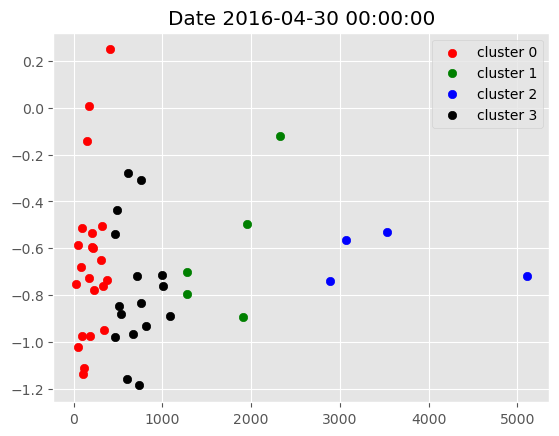

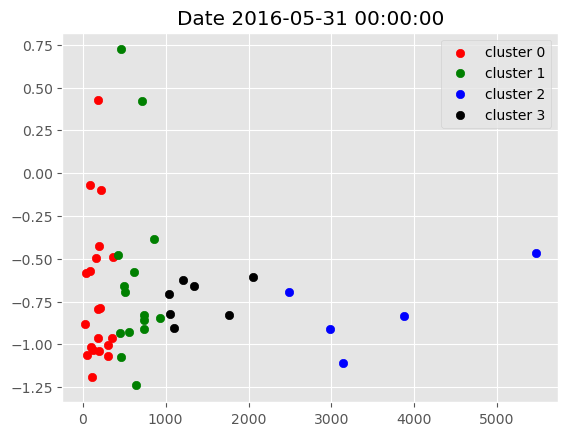

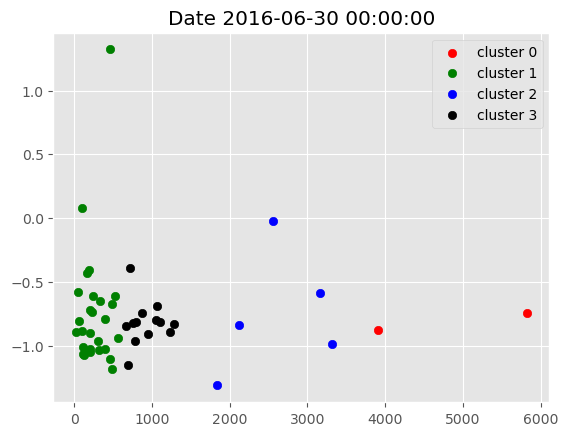

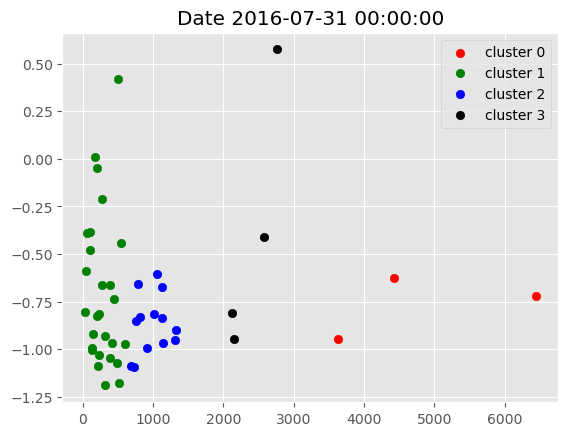

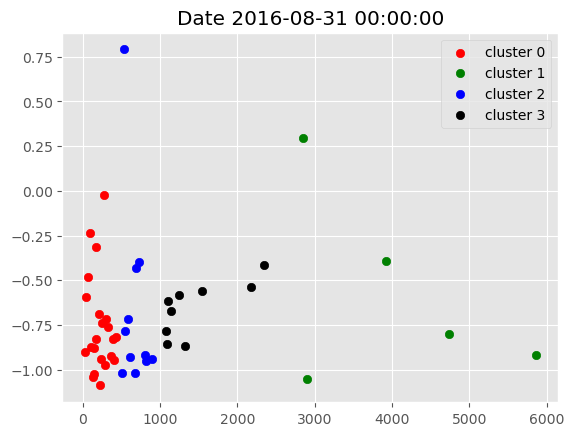

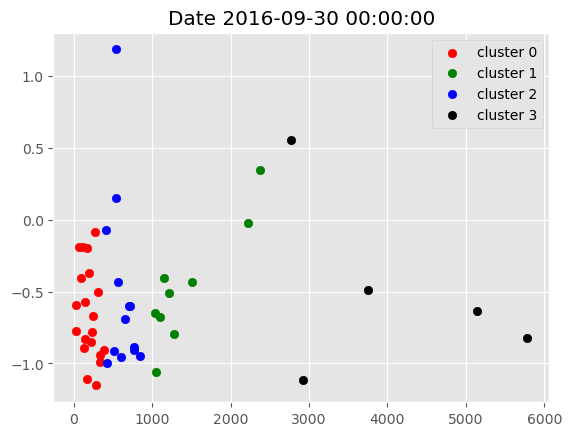

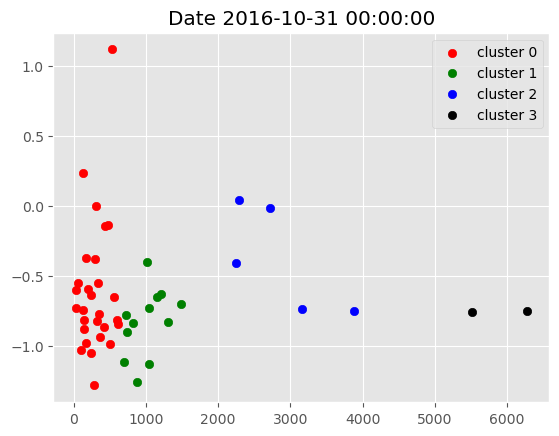

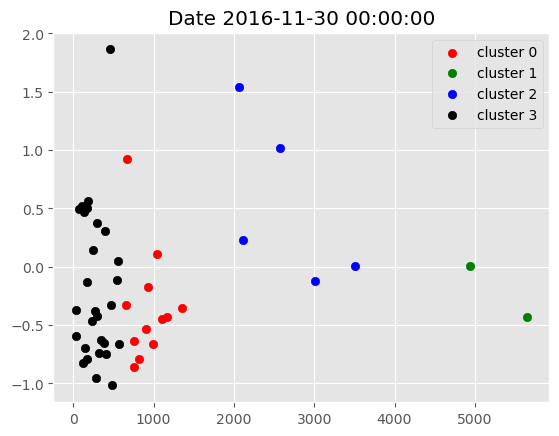

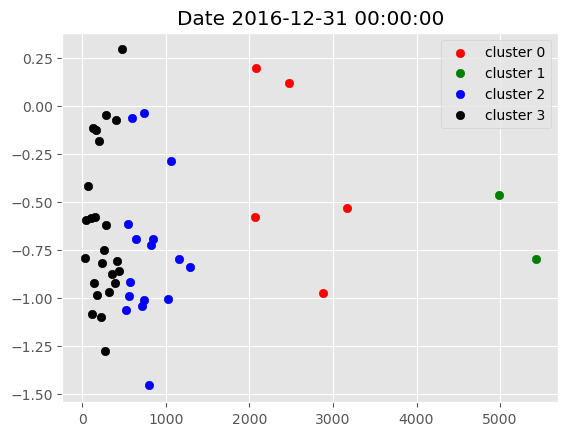

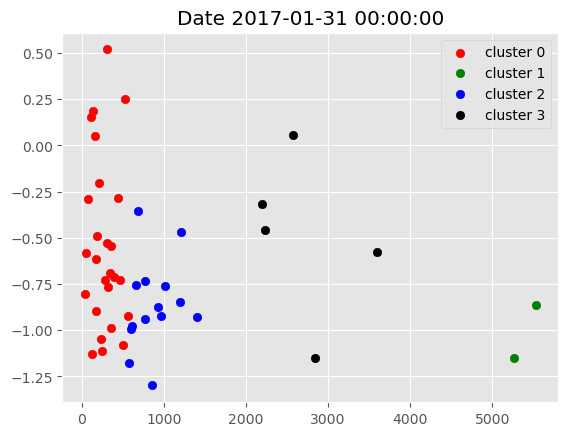

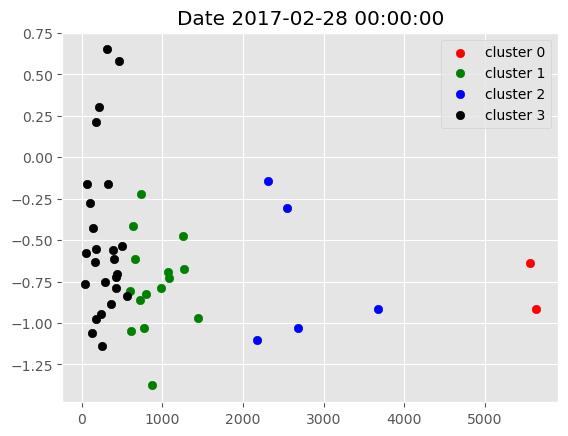

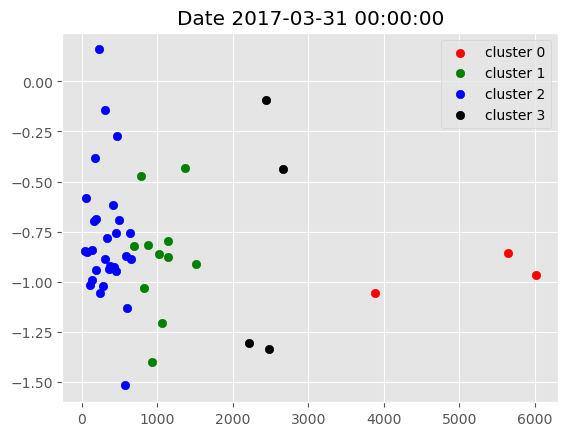

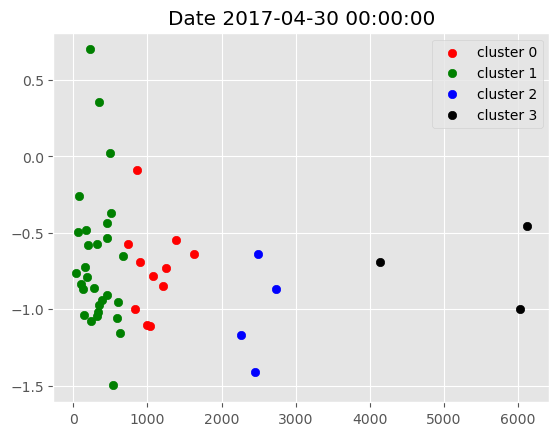

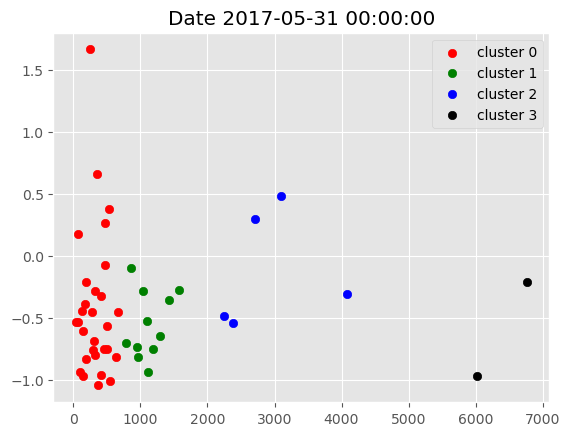

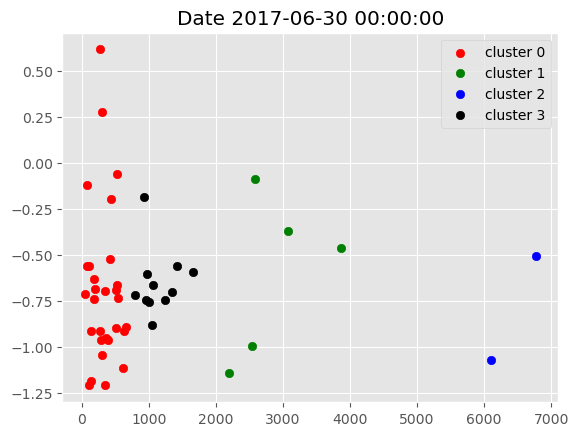

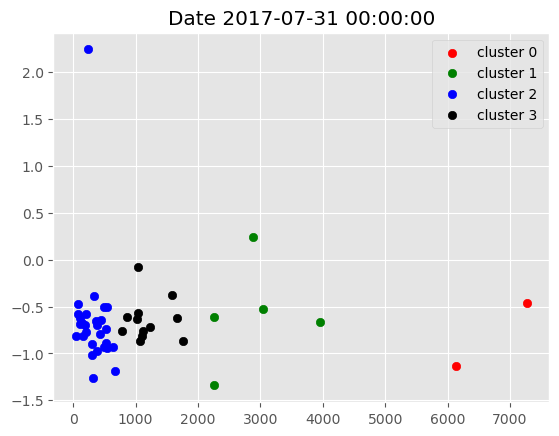

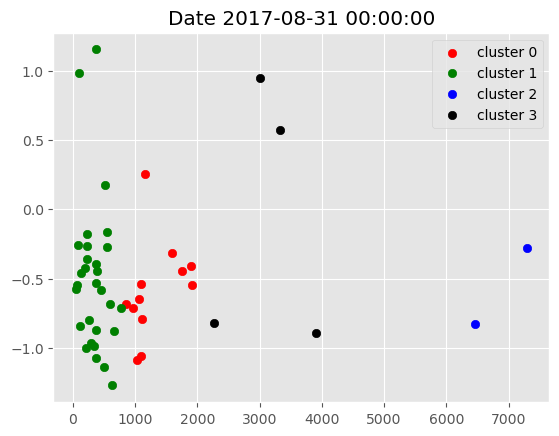

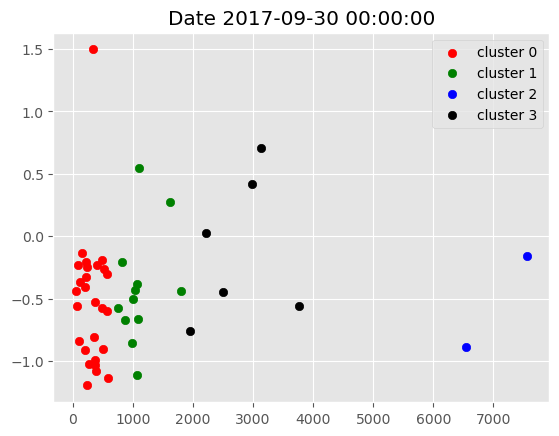

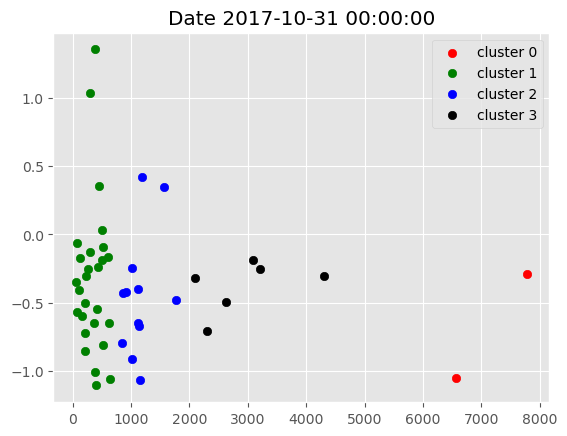

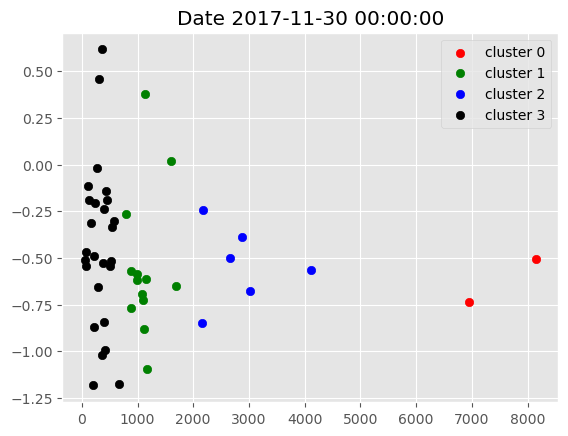

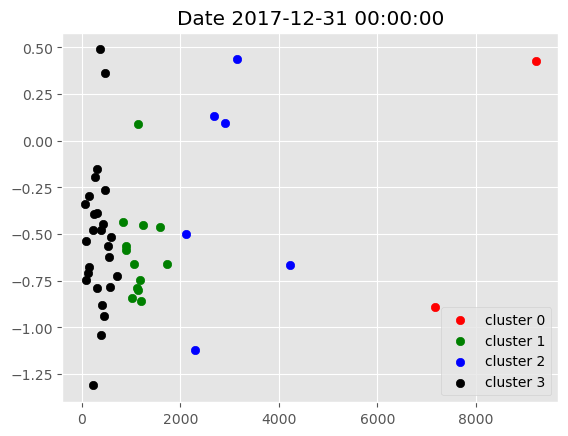

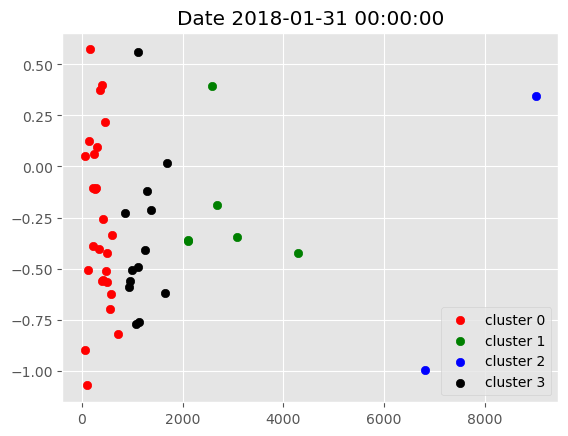

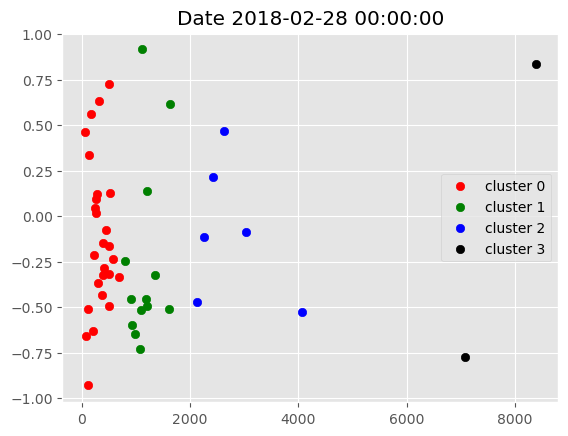

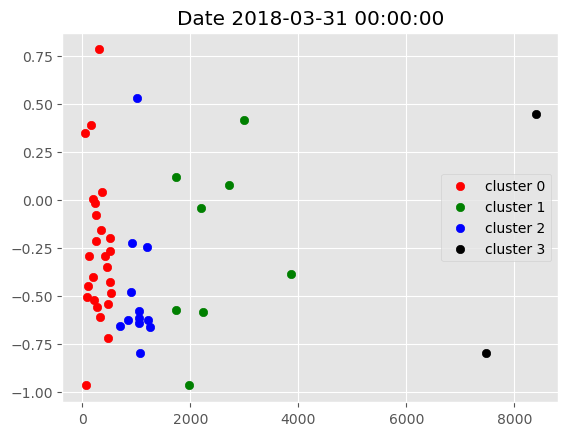

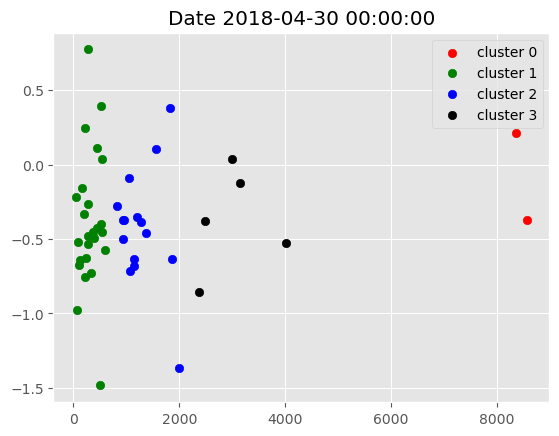

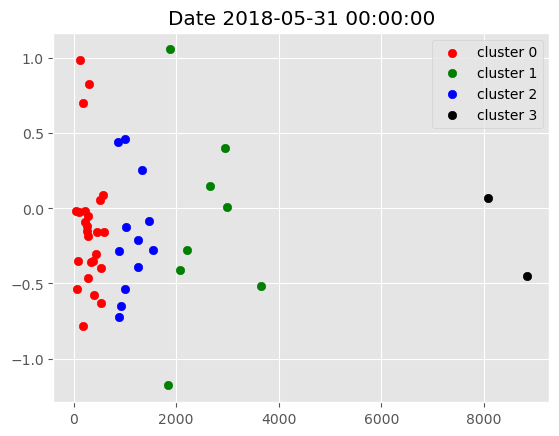

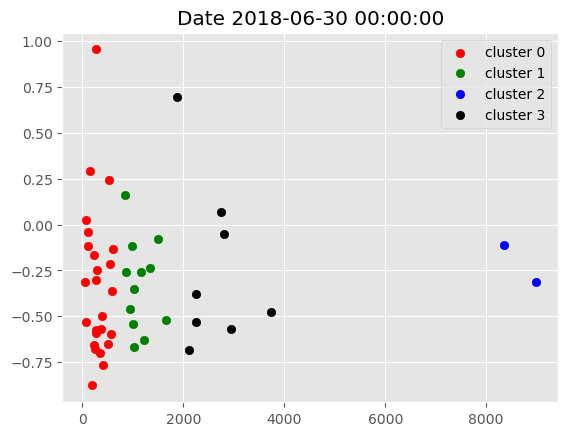

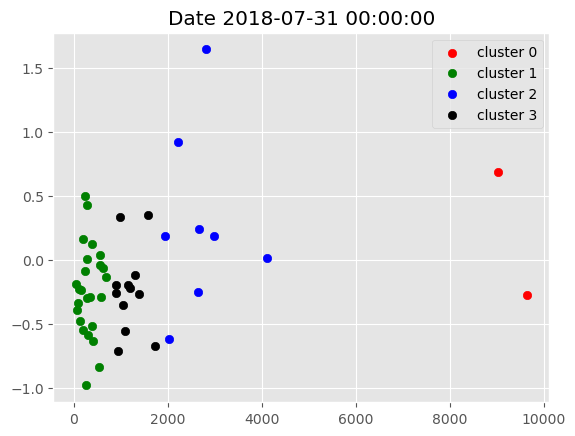

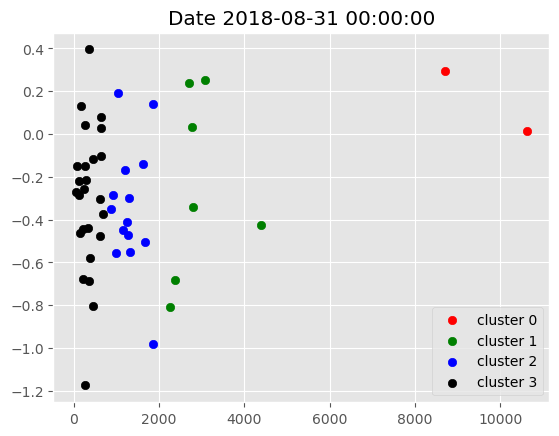

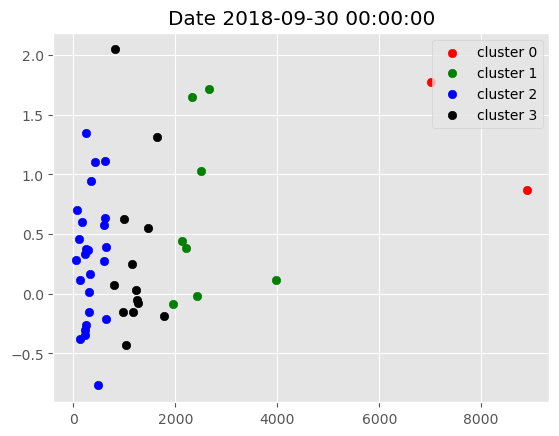

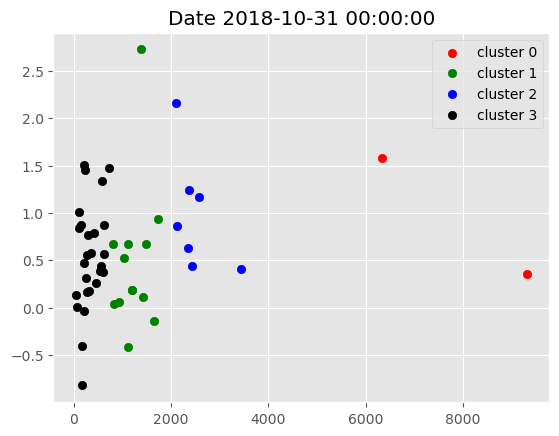

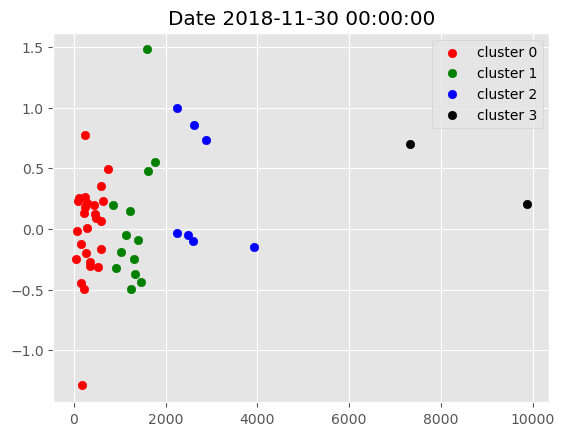

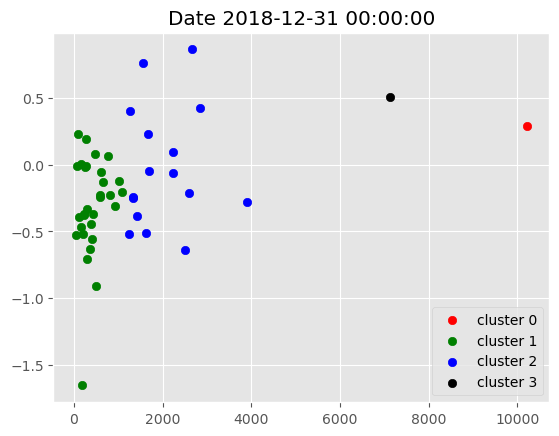

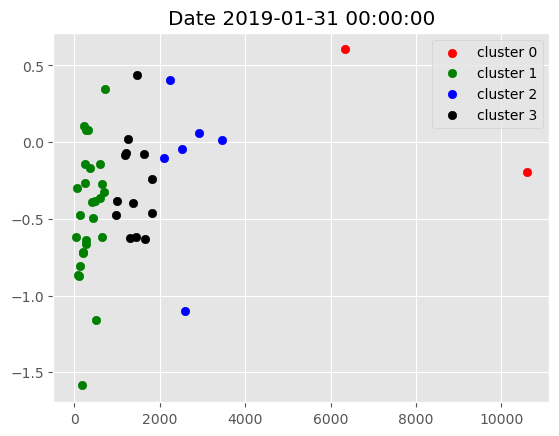

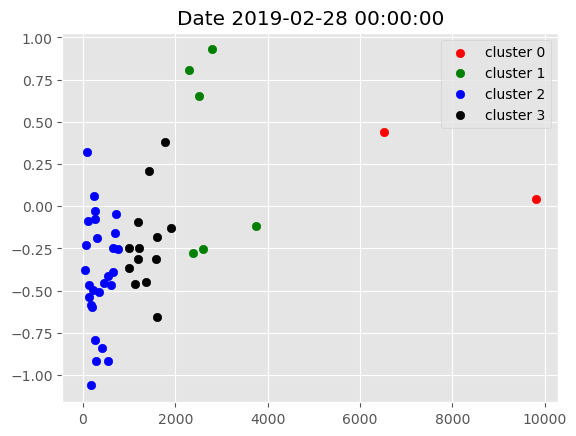

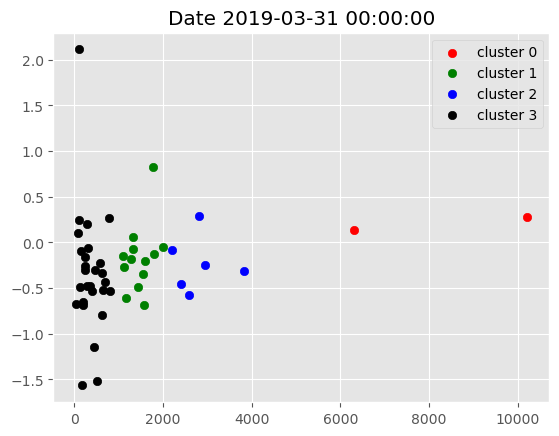

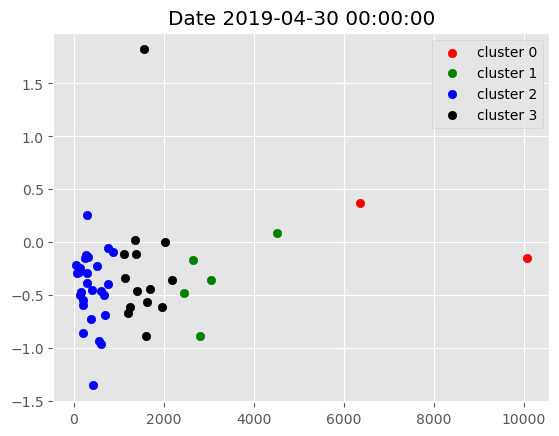

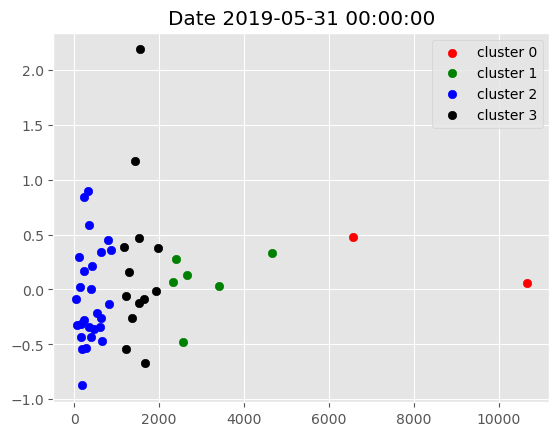

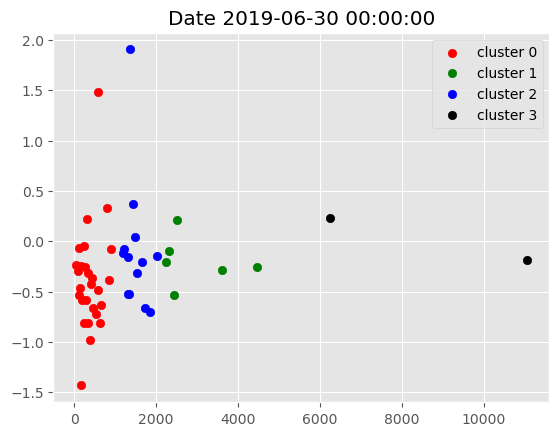

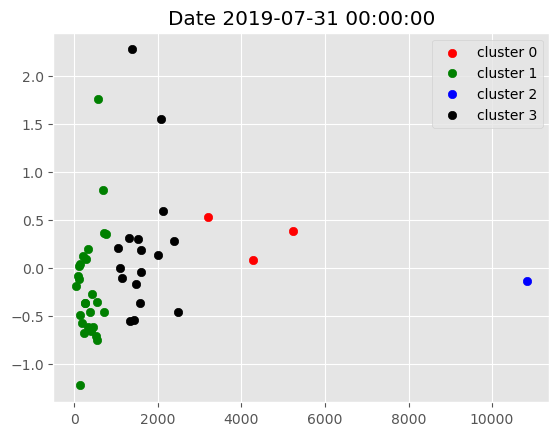

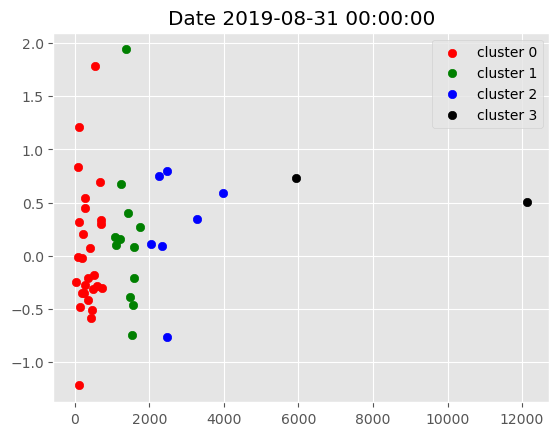

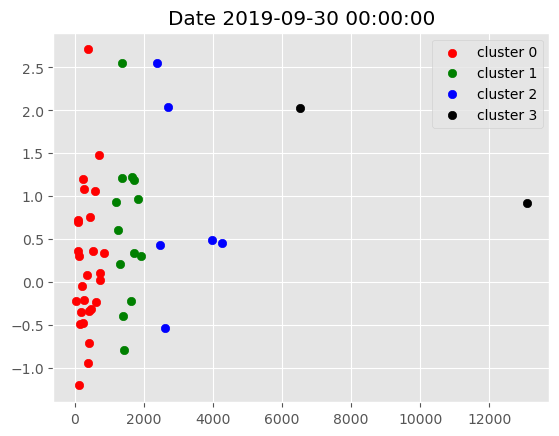

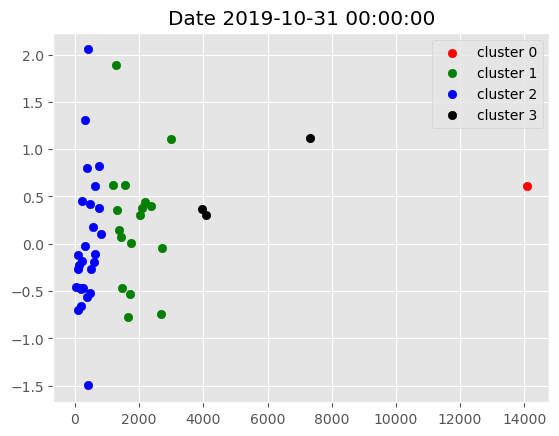

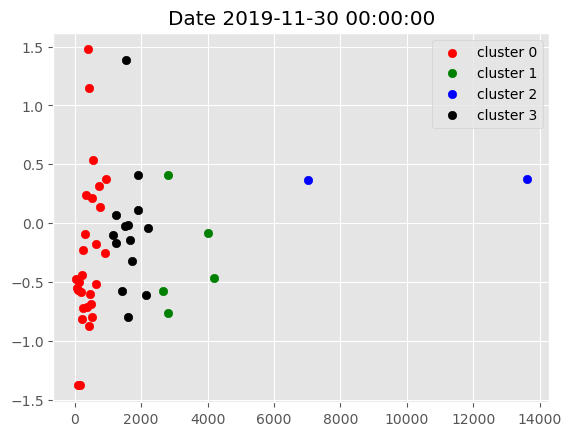

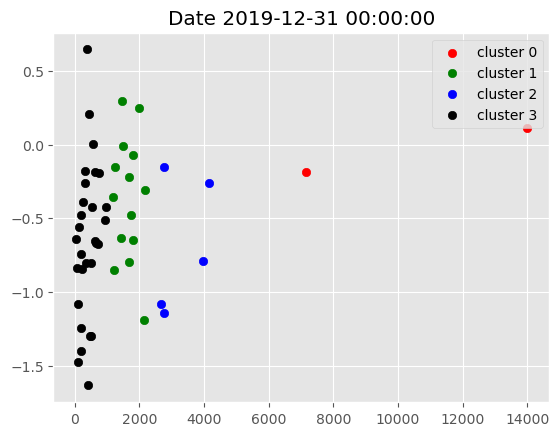

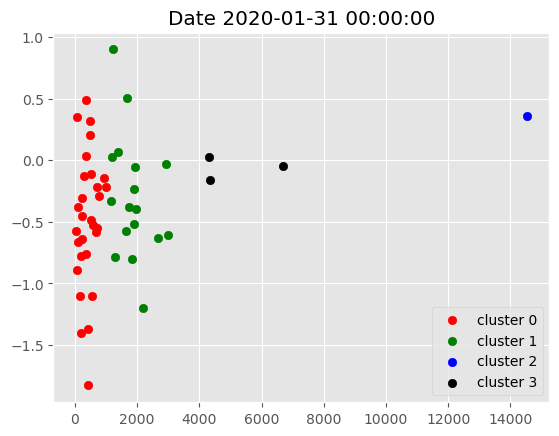

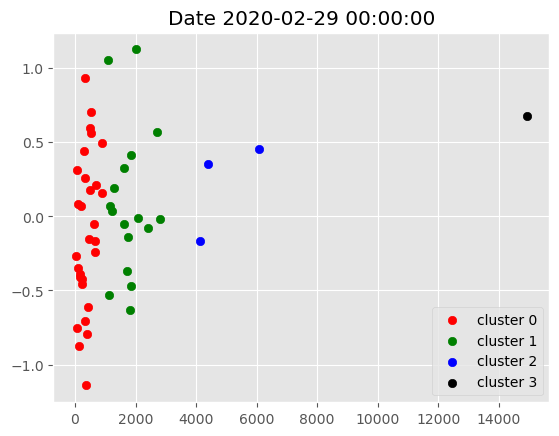

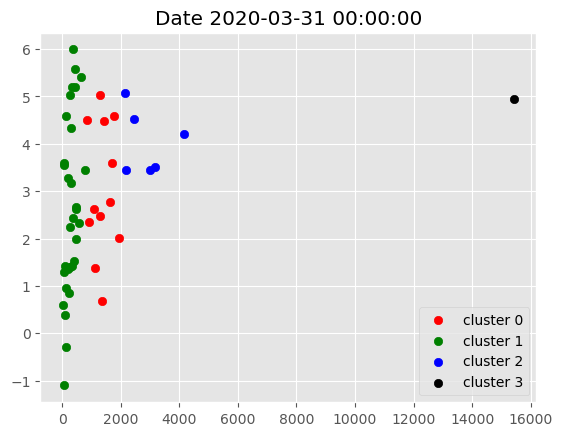

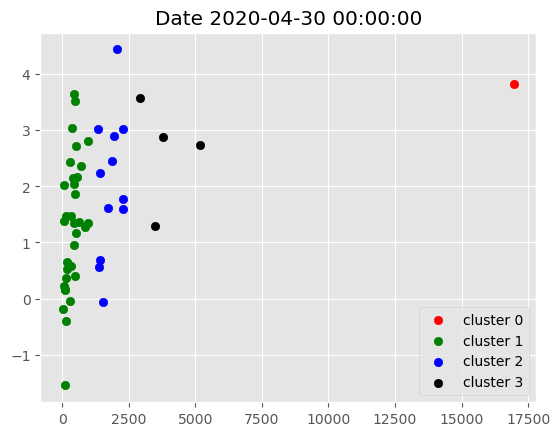

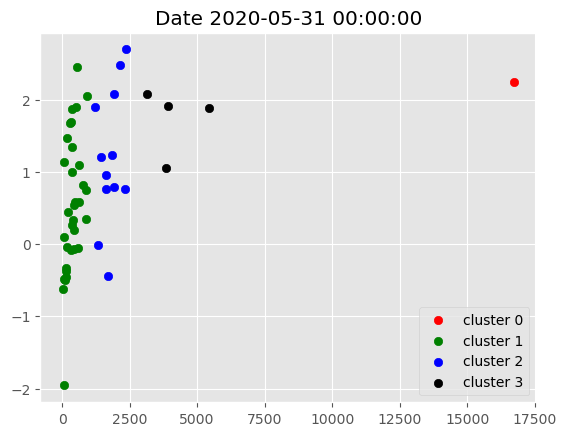

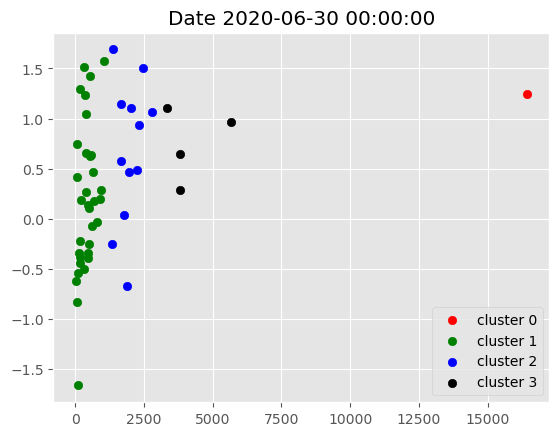

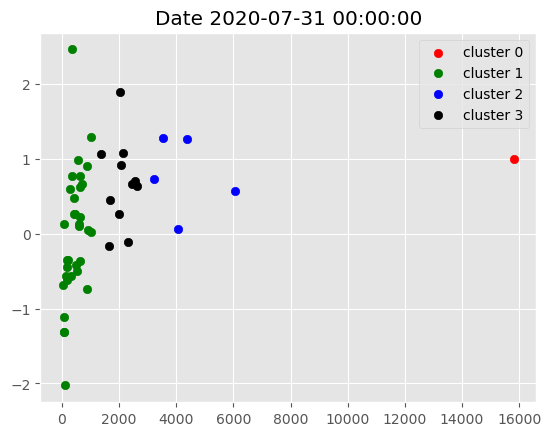

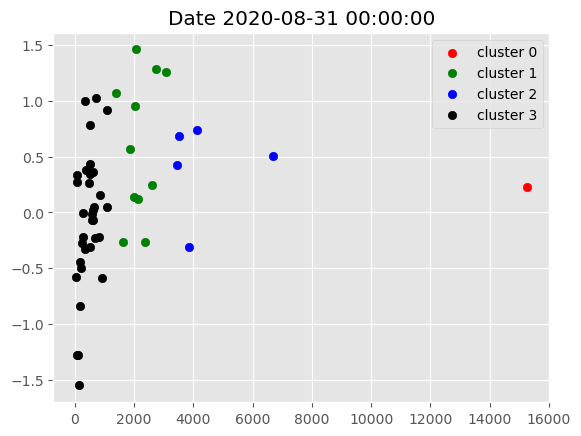

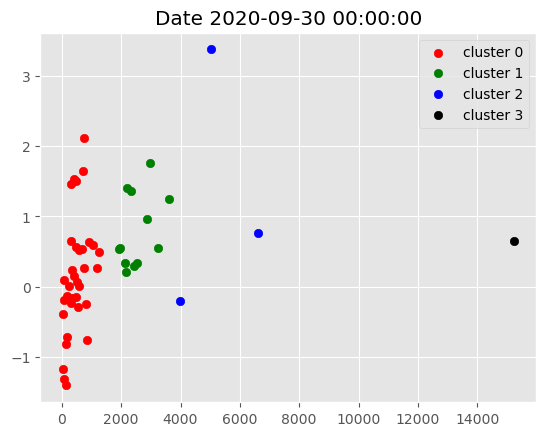

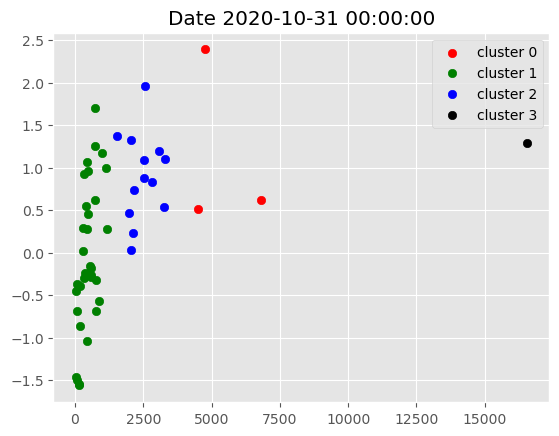

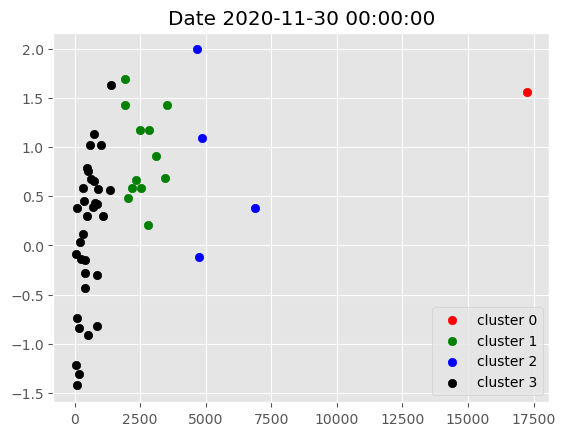

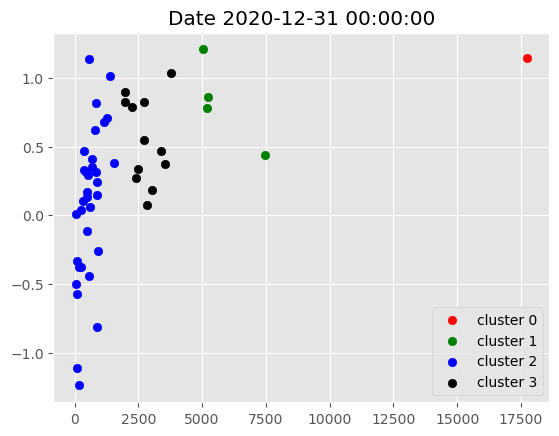

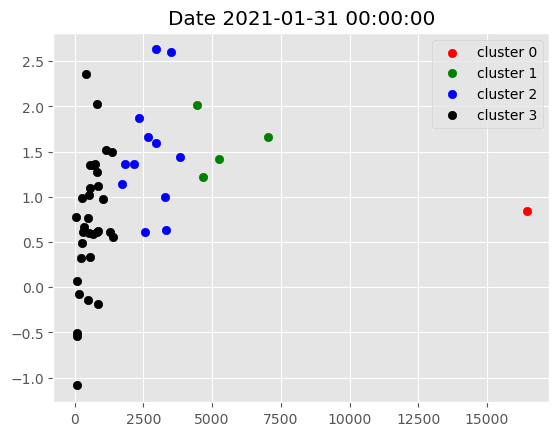

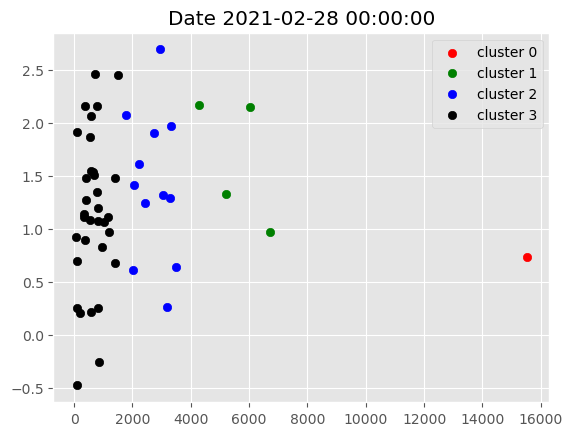

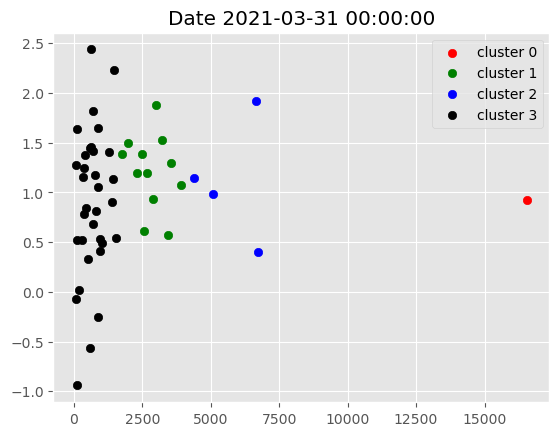

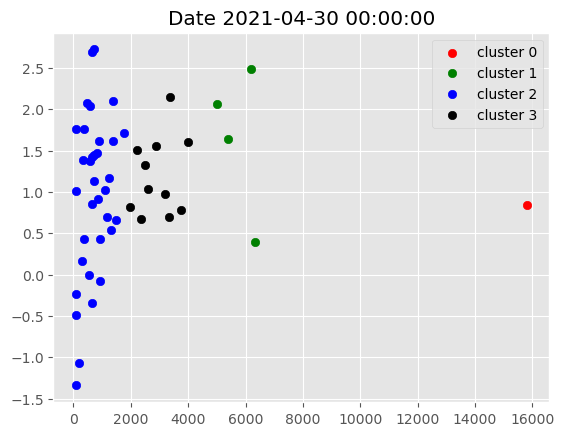

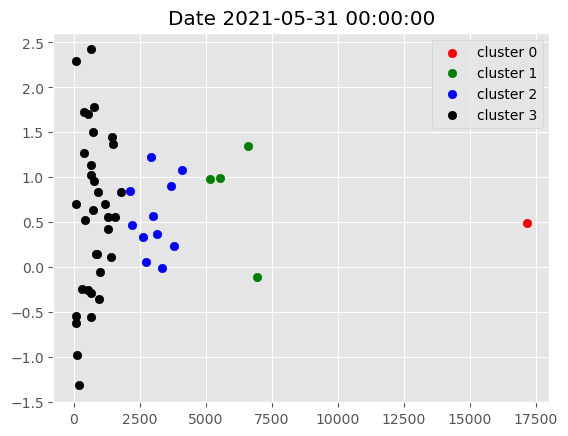

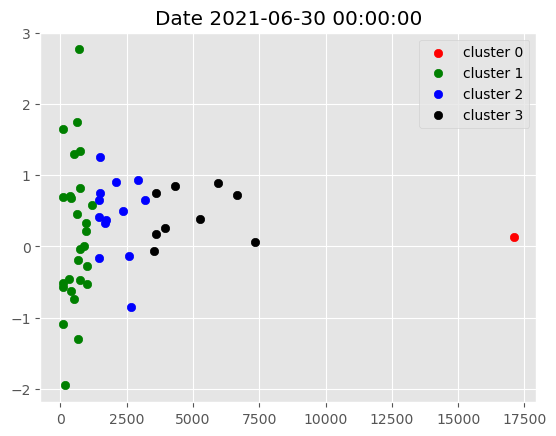

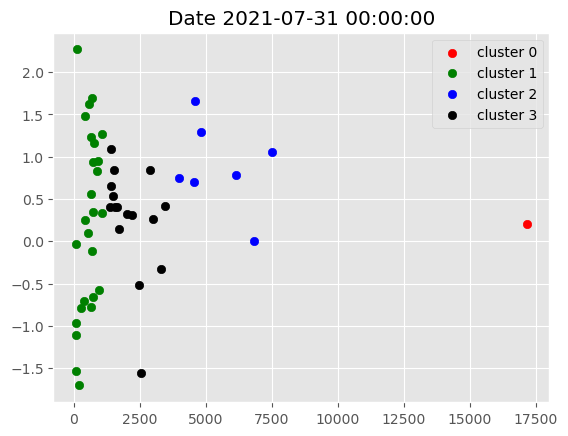

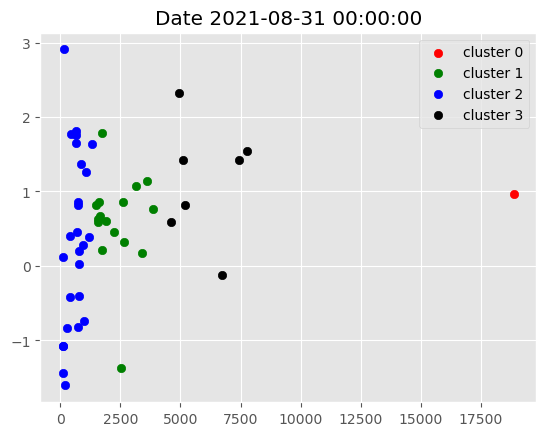

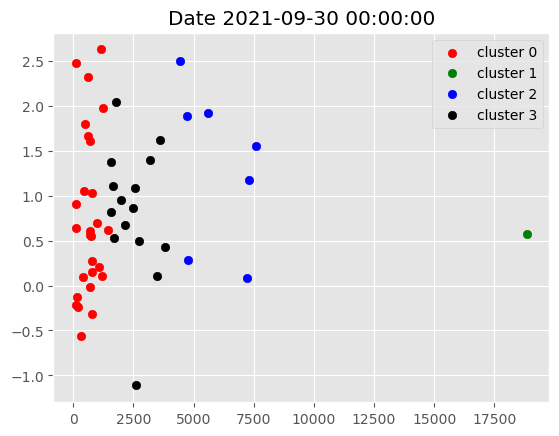

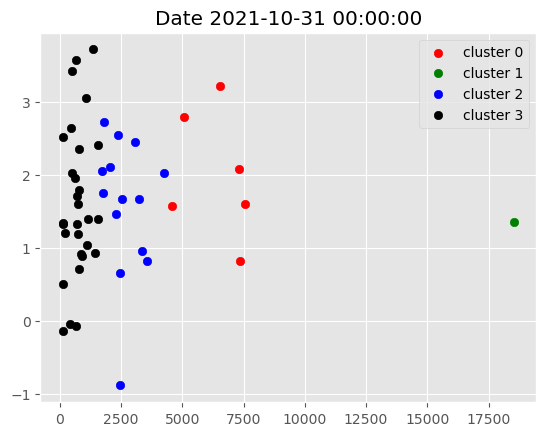

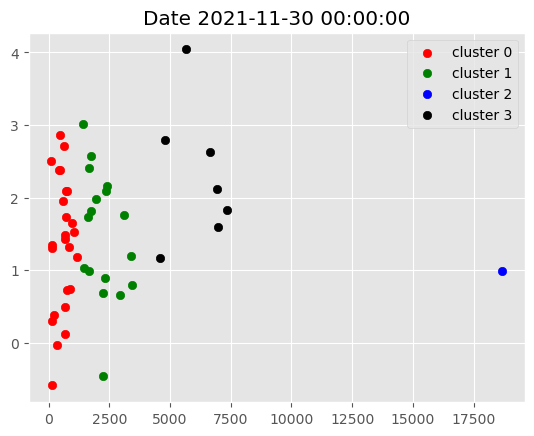

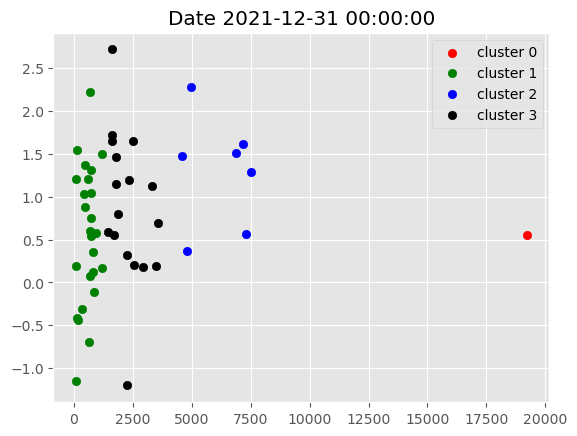

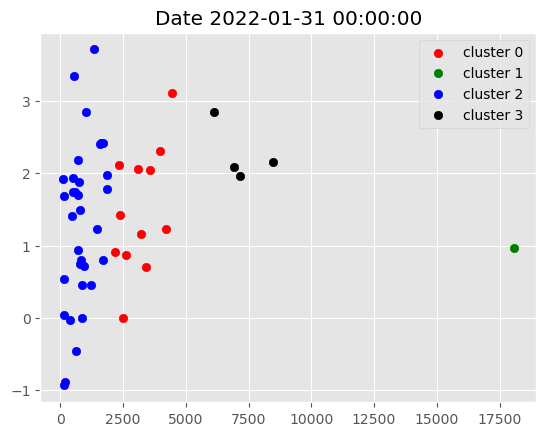

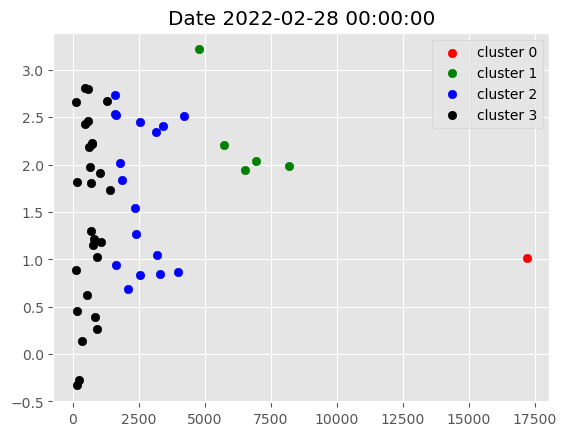

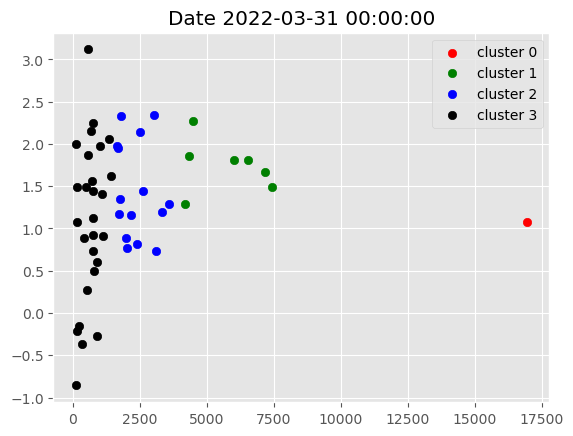

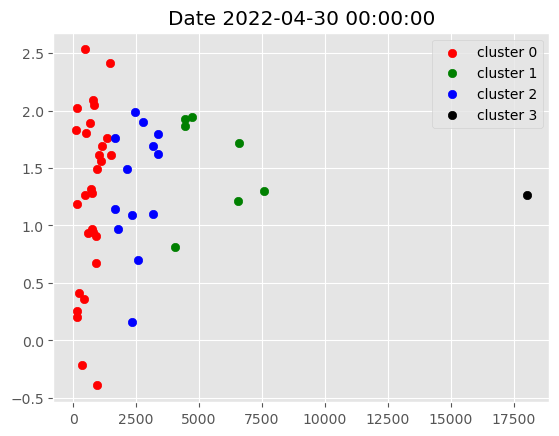

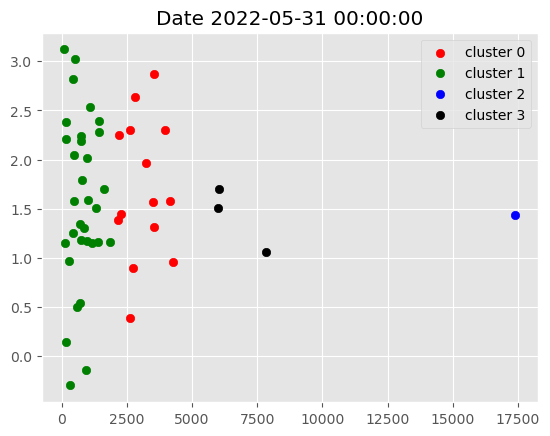

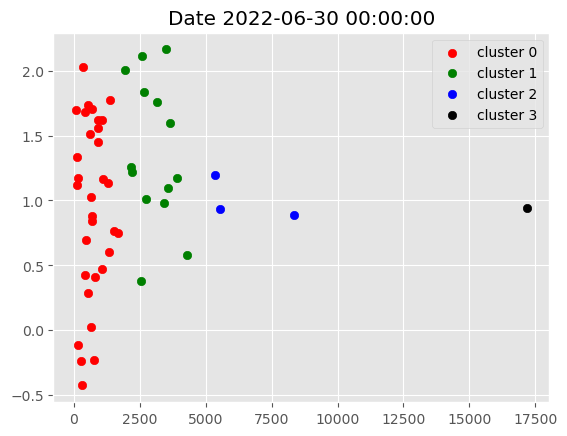

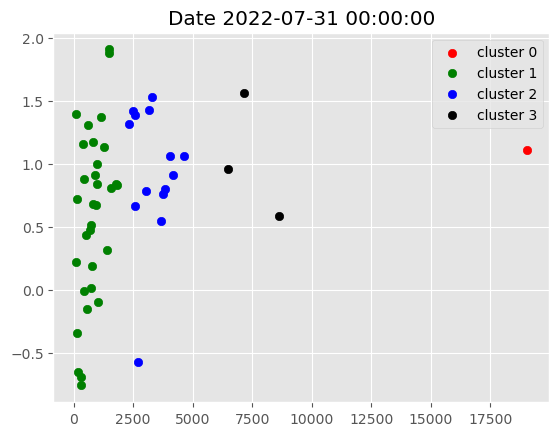

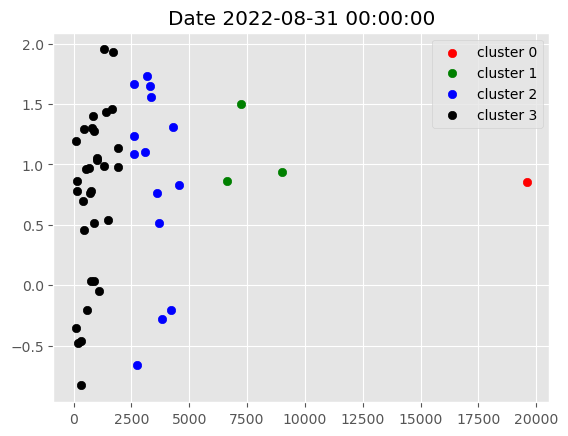

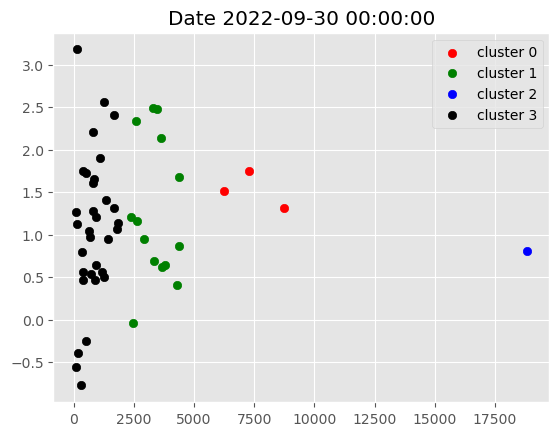

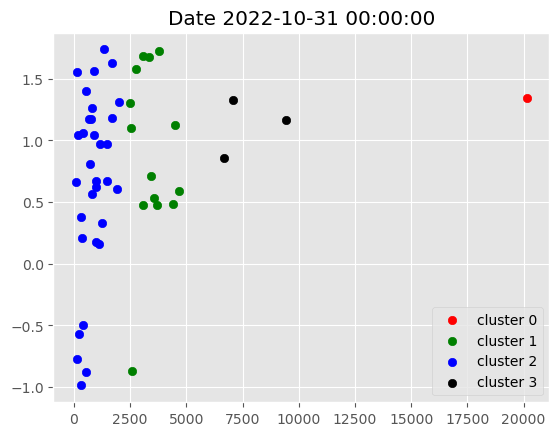

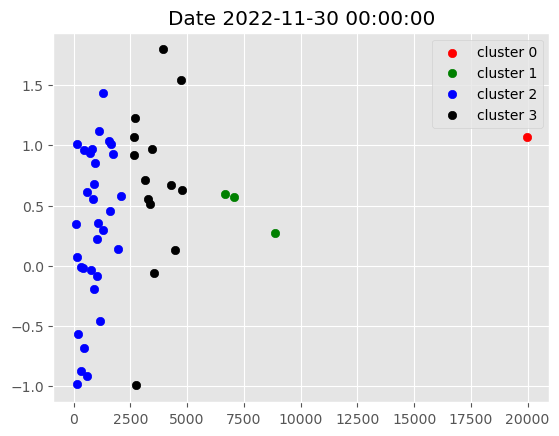

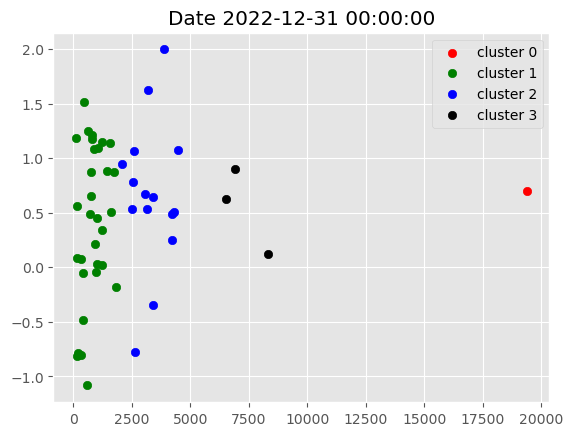

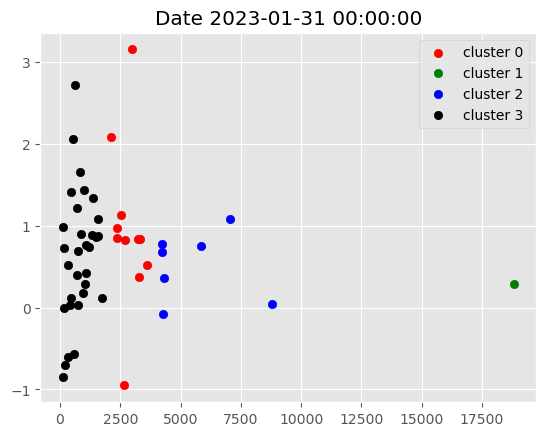

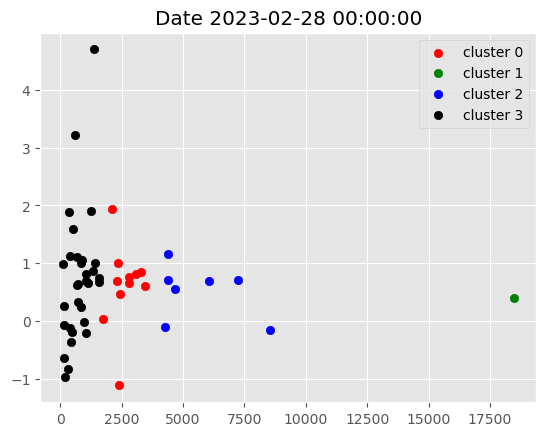

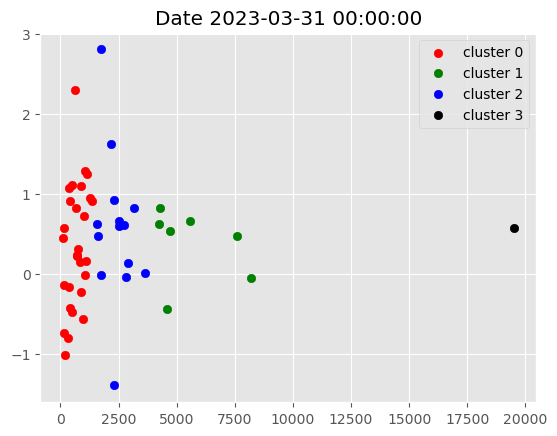

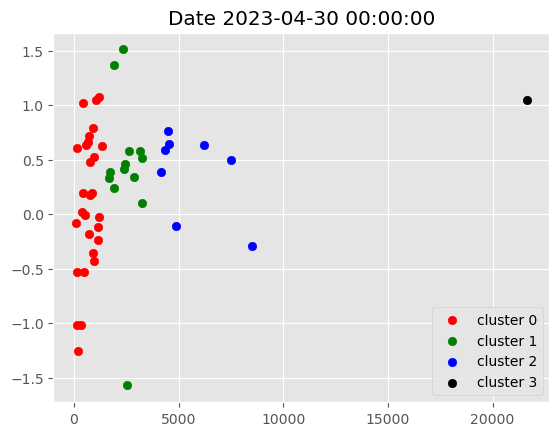

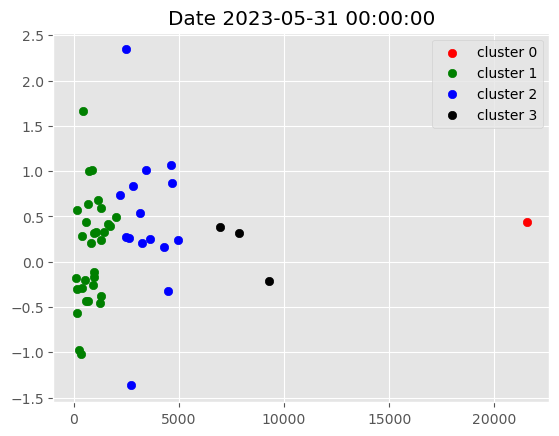

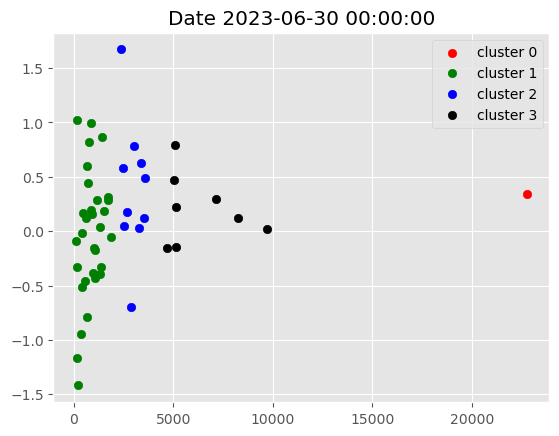

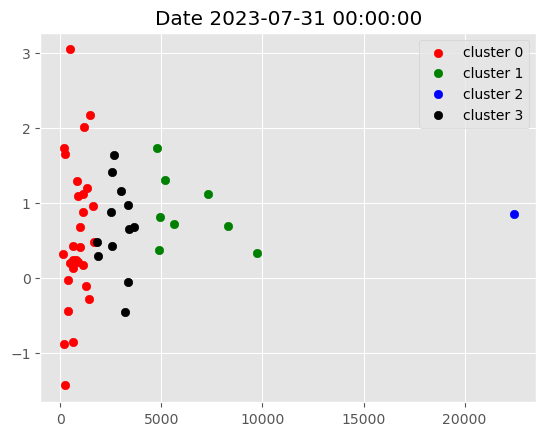

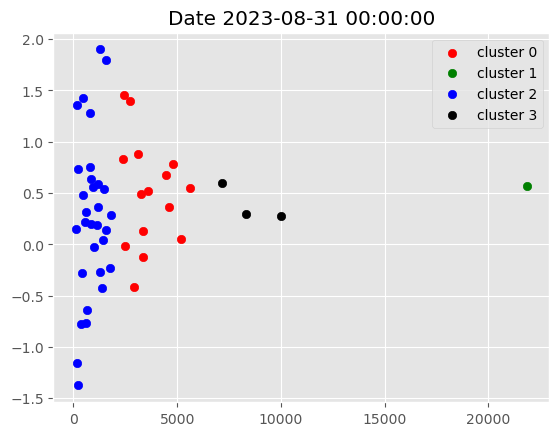

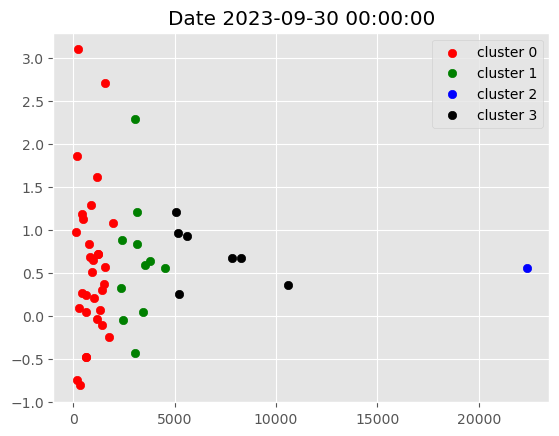

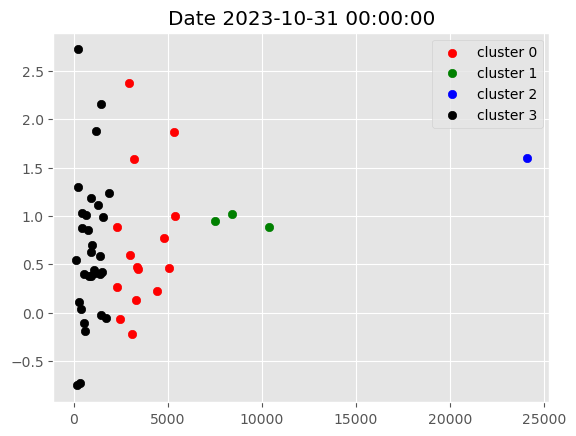

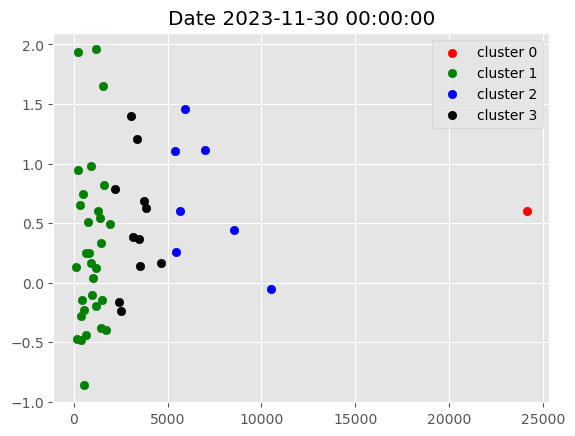

In [29]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)


### 6. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [30]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2015-09-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'],
 '2015-10-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS'],
 '2015-11-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'COALINDIA.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'INFY.NS',
  'ITC.NS',
  'JSWSTEEL.NS',
  'NTPC.NS',
  'ONGC.NS',
  'POWERGRID.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TATACONSUM.NS',
  'TATAMOTORS.NS',
  'TATASTEEL.NS',
  'TECHM.NS',
  'TITAN.NS',
  'UPL.NS',
  'WIPRO.NS'],
 '2015-12-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'COALINDIA.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'JSWSTEEL.NS',
  'NTPC.NS',
  'ONGC.NS',
  'POWERGRID.NS',
  'SBIN.NS',
  'TATACONSUM.NS',
  'TATASTEEL.NS',
  'TITAN.NS',
  'UPL.NS',
  'WIPRO.NS'],
 '2016-01-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'BPCL.NS

### Define portfolio optimization function

We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

 * Download Fresh Daily Prices Data only for short listed stocks.

In [32]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2014-09-01    70.555199    273.044342   1151.942871    589.992798   
2014-09-02    71.175552    275.283966   1140.908691    584.793457   
2014-09-03    71.745415    275.522217   1145.796753    586.760864   
2014-09-04    74.198006    275.712769   1134.617432    592.381653   
2014-09-05    73.534363    276.522888   1123.486572    606.152405   
...                 ...           ...           ...           ...   
2023-11-20  2149.850098    803.599976   5473.950195   3140.350098   
2023-11-21  2196.649902    801.349976   5466.799805   3133.250000   
2023-11-22  2172.649902    791.900024   5532.000000   3133.000000   
2023-11-23  2175.250000    793.099976   5493.950195   3122.949951   
2023-11-24  2225.449951    795.549988   5401.299805   3136.149902   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2014-09-01   393.074188   1704.042969    106.185509    236.699493   
2014-09-02   396.807098   1702.573120    109.612274    235.932266   
2014-09-03   401.121765   1677.885742    109.254196    241.448746   
2014-09-04   403.739685   1735.213379    109.288994    237.393906   
2014-09-05   403.303406   1763.670044    109.269112    236.684937   
...                 ...           ...           ...           ...   
2023-11-20   988.700012   5650.149902   1593.800049   7068.600098   
2023-11-21   991.799988   5685.950195   1610.400024   7103.149902   
2023-11-22   998.099976   5751.549805   1623.900024   7128.350098   
2023-11-23   999.049988   5925.250000   1623.949951   7073.649902   
2023-11-24  1008.500000   5930.299805   1617.250000   7020.799805   

                                      ...       Volume                \
           BHARTIARTL.NS     BPCL.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                  ...                              
2014-09-01    329.782715  146.641327  ...      1923611       1611331   
2014-09-02    343.648010  146.391693  ...      1949092       1903051   
2014-09-03    354.968414  146.578949  ...      2005404       1808768   
2014-09-04    354.968414  145.788330  ...      1095221       5685443   
2014-09-05    351.984741  146.843781  ...      1179280       4436559   
...                  ...         ...  ...          ...           ...   
2023-11-20    961.400024  392.000000  ...      1054810       1169030   
2023-11-21    970.849976  388.000000  ...       999135        804344   
2023-11-22    969.750000  402.100006  ...      1401782        885449   
2023-11-23    976.650024  411.299988  ...      1177434        907511   
2023-11-24    973.150024  410.600006  ...      1376695        521207   

                                                                  \
           TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2014-09-01       6321716     56107572   810148  1056464  1027263   
2014-09-02       4700852     38674664  1407940  1714096  1469921   
2014-09-03       7395355     56738040  3061690  1904628  1185735   
2014-09-04       7887159     58646437  1701598  1344788  1055883   
2014-09-05      10061738     46089630  1467060  1715668   906203   
...                  ...          ...      ...      ...      ...   
2023-11-20       8324354     18780290  1475621  1077366   497379   
2023-11-21       7291057     29643312  1807236  1129326  1038863   
2023-11-22       9279642     19588063  1798051   750622   980779   
2023-11-23       5885370     30736851  2729804   651637   517362   
2023-11-24       6951690     14719450  1989733   884921   589530   

                                            
           ULTRACEMCO.NS   UPL.NS WIPRO.NS  
Date                        

 * Calculate daily returns for each stock which could land up in our portfolio.

 * Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

 * If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

 * Calculated each day portfolio return.

In [33]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

Max Sharpe Optimization failed for 2015-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2015-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2016-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights

In [34]:
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

,Strategy Return
date,
2015-09-01,-0.012827
2015-09-02,-0.003378
2015-09-03,0.021875
2015-09-04,-0.023492
2015-09-07,-0.011286
...,...
2023-11-20,-0.000441
2023-11-21,0.002923
2023-11-22,0.002296


### 7. Visualize Portfolio returns and compare to SP500 returns.

In [35]:
nifty_df = yf.download("^NSEI", start, end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [36]:
nifty_ret = np.log(nifty_df[['Adj Close']]).diff().dropna().rename({'Adj Close':'Nifty Buy&Hold'}, axis=1)


In [37]:
portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,Nifty Buy&Hold
2015-09-01,-0.012827,-0.023540
2015-09-02,-0.003378,-0.008882
2015-09-03,0.021875,0.013642
2015-09-04,-0.023492,-0.021703
2015-09-07,-0.011286,-0.012653
...,...,...
2023-11-20,-0.000441,-0.001918
2023-11-21,0.002923,0.004529
2023-11-22,0.002296,0.001437
2023-11-23,-0.000843,-0.000497


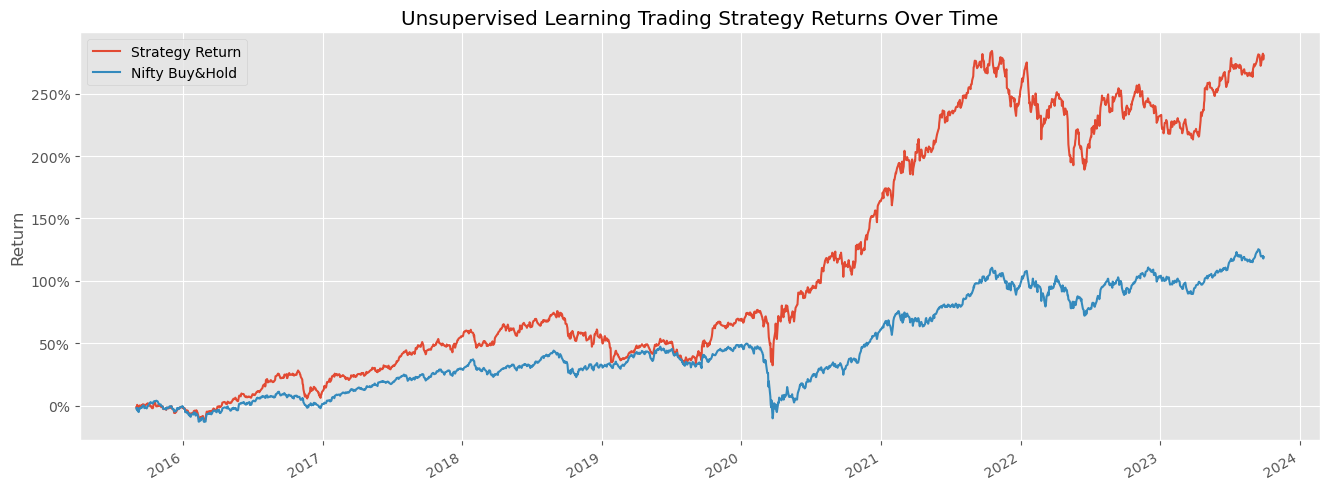

In [38]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [48]:
 def analysis(data, risk_free_rate=0.02):
        # Calculate daily returns
        daily_returns = data

        # Annualized mean return and standard deviation
        annualized_mean_return = daily_returns.mean() * 252
        annualized_std_dev = daily_returns.std() * np.sqrt(252)

        # Sharpe ratio
        sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_std_dev

        # Drawdown
        previous_peaks = data.cummax()
        drawdown = data - previous_peaks
        max_drawdown = drawdown.min()

        # Sortino ratio
        downside_returns = daily_returns[daily_returns < 0]
        downside_std_dev = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_mean_return - risk_free_rate) / downside_std_dev if downside_std_dev != 0 else float('inf')

        print("Sharpe Ratio:", sharpe_ratio)
        print("Max Drawdown:", max_drawdown)
        print("Sortino Ratio:", sortino_ratio)

In [49]:
final_df = portfolio_df['Strategy Return']

In [50]:
strategy_analysis = analysis(final_df)

Sharpe Ratio: 0.8727033471968978
Max Drawdown: -0.17739288802323872
Sortino Ratio: 1.1773585301464902
